In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
from __future__ import division, print_function, absolute_import
print('Importing libraries...')
import pickle
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from skimage import transform #For downsizing images
from sklearn.model_selection import train_test_split

Importing libraries...


In [3]:
# Creating features dataset
# unpickling the image files
with open ('/content/drive/MyDrive/population density satellite data/dataX', 'rb') as fp:
    dataX = pickle.load(fp)
print('Features dataset finished with shape', dataX.shape)


Features dataset finished with shape (7000, 200, 200, 3)


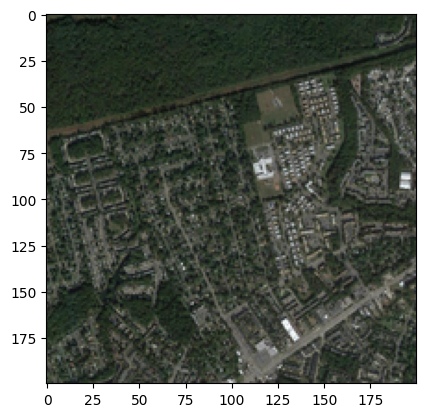

In [4]:
import cv2
import matplotlib.pyplot as plt
temp = cv2.cvtColor(dataX[465], cv2.COLOR_BGR2RGB)
plt.imshow(temp)
#plt.imshow(imageio.imread('./images/0_0.png'))
plt.show()

In [5]:
# unpickling labels file
with open ('/content/drive/MyDrive/population density satellite data/dataY', 'rb') as fp:
    dataY = pickle.load(fp)
print('Labels dataset finished with shape', dataY.shape)

Labels dataset finished with shape (7000,)


In [6]:
print(dataY[465])

2604.789675


## Data Processing

In [7]:
X_train = []
X_test = []
Y_train = []
Y_test = []

In [8]:
dataX.shape[0]

7000

In [9]:
# Custom train/test splitting
for n in range(dataX.shape[0]):
    if not n%10:
        X_train.append(dataX[n])
        X_train.append(dataX[n+1])
        X_train.append(dataX[n+2])
        X_train.append(dataX[n+3])
        X_train.append(dataX[n+4])
        X_train.append(dataX[n+5])
        X_train.append(dataX[n+6])
        X_train.append(dataX[n+7])
        X_test.append(dataX[n+8])
        X_test.append(dataX[n+9])

        Y_train.append(dataY[n])
        Y_train.append(dataY[n+1])
        Y_train.append(dataY[n+2])
        Y_train.append(dataY[n+3])
        Y_train.append(dataY[n+4])
        Y_train.append(dataY[n+5])
        Y_train.append(dataY[n+6])
        Y_train.append(dataY[n+7])
        Y_test.append(dataY[n+8])
        Y_test.append(dataY[n+9])

In [10]:
# Convert the data into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(5600, 200, 200, 3) (1400, 200, 200, 3) (5600,) (1400,)


In [11]:
# # Normalize the Input data
# X_train = X_train/255
# X_test = X_test/255

In [12]:
# Check the normailzed output
X_train[0]

array([[[ 54,  85,  58],
        [ 59,  82,  60],
        [ 62,  89,  69],
        ...,
        [ 31,  44,  28],
        [ 44,  60,  36],
        [ 51,  67,  44]],

       [[ 59,  91,  67],
        [ 64,  90,  70],
        [ 78, 107,  89],
        ...,
        [ 28,  42,  25],
        [ 49,  65,  41],
        [ 53,  68,  46]],

       [[ 65,  99,  77],
        [ 71,  98,  80],
        [ 62,  93,  78],
        ...,
        [ 52,  65,  49],
        [ 47,  64,  39],
        [ 43,  59,  37]],

       ...,

       [[ 43,  61,  39],
        [ 46,  67,  42],
        [ 44,  70,  41],
        ...,
        [ 36,  61,  37],
        [ 44,  76,  48],
        [ 36,  62,  32]],

       [[ 38,  60,  34],
        [ 49,  73,  45],
        [ 57,  87,  54],
        ...,
        [ 33,  57,  33],
        [ 41,  65,  38],
        [ 46,  71,  41]],

       [[ 49,  73,  45],
        [ 57,  85,  53],
        [ 55,  88,  52],
        ...,
        [ 49,  71,  48],
        [ 37,  54,  29],
        [ 45,  70,  40]]

In [13]:
# Convert the true image labels to label classes
def classify(t):
    i = 0
    for n in t:
        if (n<1):
            t[i] = 0
            i+=1
        if (1<=n) and (n<10):
            t[i] = 1
            i+=1
        if (10<=n) and (n<50):
            t[i] = 2
            i+=1
        if (50<=n) and (n<100):
            t[i] = 3
            i+=1
        if (100<=n) and (n<500):
            t[i] = 4
            i+=1
        if (500<=n) and (n<1000):
            t[i] = 5
            i+=1
        if (1000<=n) and (n<2000):
            t[i] = 6
            i+=1
        if (2000<=n):
            t[i] = 7
            i+=1
    return t

In [14]:
Y_train = classify(Y_train)
Y_test = classify(Y_test)

In [15]:
Y_train[465]

6.0

## Model Training

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.applications import DenseNet121
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

In [17]:

# Convert labels to categorical labels
Y_train = to_categorical(Y_train - 1, num_classes=8)
Y_test = to_categorical(Y_test - 1, num_classes=8)


In [18]:
# download the base DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 [==============================] - 0s 0us/step


In [19]:
# Data additional NN layers at the end of the network
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model, Only run when training the model
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/40
175/175 [==============================] - 37s 120ms/step - loss: 2.0960 - accuracy: 0.4048 - val_loss: 1.2898 - val_accuracy: 0.5307
Epoch 2/40
175/175 [==============================] - 16s 93ms/step - loss: 1.3488 - accuracy: 0.5046 - val_loss: 1.1750 - val_accuracy: 0.5500
Epoch 3/40
175/175 [==============================] - 16s 94ms/step - loss: 1.2170 - accuracy: 0.5446 - val_loss: 1.1123 - val_accuracy: 0.5743
Epoch 4/40
175/175 [==============================] - 19s 106ms/step - loss: 1.1410 - accuracy: 0.5623 - val_loss: 1.0969 - val_accuracy: 0.5693
Epoch 5/40
175/175 [==============================] - 17s 96ms/step - loss: 1.0936 - accuracy: 0.5714 - val_loss: 1.0588 - val_accuracy: 0.5879
Epoch 6/40
175/175 [==============================] - 17s 95ms/step - loss: 1.0636 - accuracy: 0.5836 - val_loss: 1.0469 - val_accuracy: 0.5957
Epoch 7/40
175/175 [==============================] - 19s 106ms/step - loss: 1.0326 - accuracy: 0.5855 - val_loss: 1.0342 - val_accura

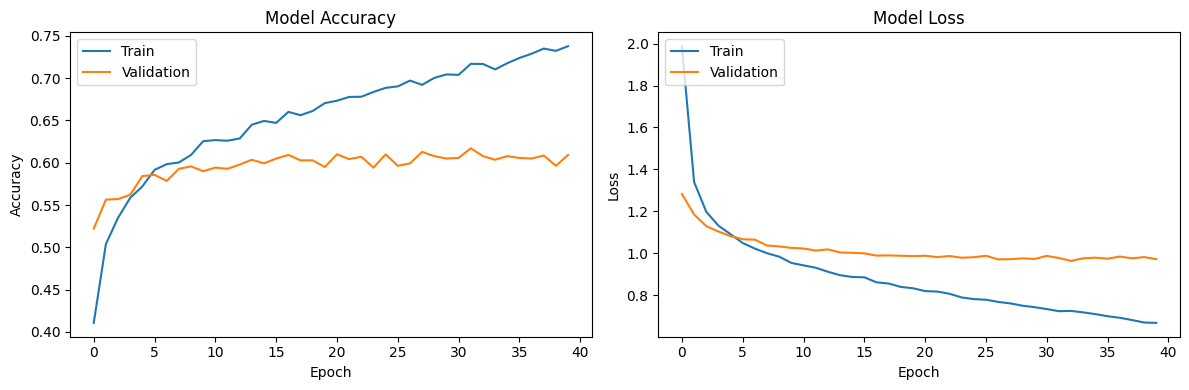

In [ ]:
# Plot the model training vs epochs plot
import matplotlib.pyplot as plt

# Assuming you've trained the model and have the `history` object containing training history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Model Evaluation


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [22]:

# Load the trained weights
# Enter the path to the directory of trained model file
model = tf.keras.models.load_model('/content/drive/MyDrive/population density satellite data/denset')

44/44 [==============================] - 6s 109ms/step


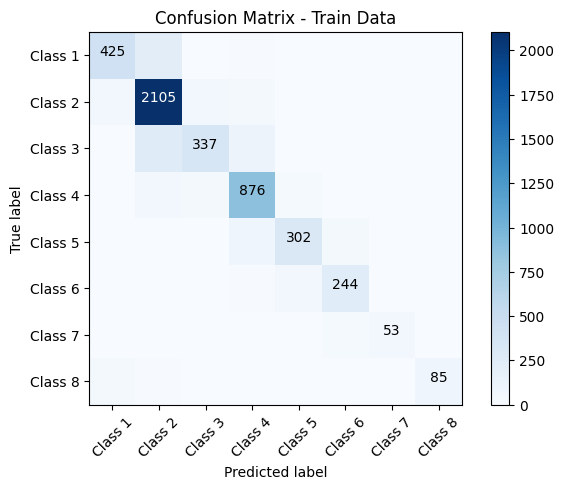

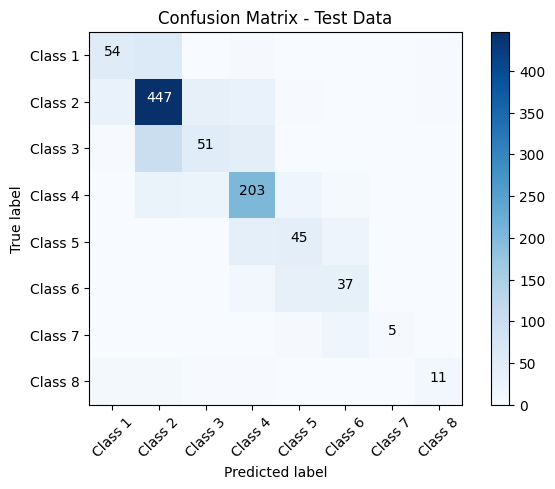

In [23]:
# Assuming you have already trained the model and obtained predictions for X_train and X_test
# train_predictions and test_predictions contain the predicted values for train and test data respectively

# train_predictions and test_predictions should contain the predicted labels/classes
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Assuming the labels are in the correct format and need conversion to class labels
train_predicted_classes = np.argmax(train_predictions, axis=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)

# Assuming Y_train and Y_test are the true labels in the correct format
# Convert one-hot encoded labels back to categorical labels
train_true_classes = np.argmax(Y_train, axis=1)
test_true_classes = np.argmax(Y_test, axis=1)

# Create confusion matrices for both train and test data
train_confusion_matrix = confusion_matrix(train_true_classes, train_predicted_classes)
test_confusion_matrix = confusion_matrix(test_true_classes, test_predicted_classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in zip(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Define the class names or labels for your problem
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']

# Plot the confusion matrix for train data
plt.figure()
plot_confusion_matrix(train_confusion_matrix, classes=class_names, title='Confusion Matrix - Train Data')

# Plot the confusion matrix for test data
plt.figure()
plot_confusion_matrix(test_confusion_matrix, classes=class_names, title='Confusion Matrix - Test Data')

plt.show()
# Train Accuracy: 0.7869
# Test Accuracy: 0.6091